## Initialising model and libraries

In [1]:
import sys

sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM,MNIST_SResFITDM_Large,Omniglot
from fit.utils.tomo_utils import get_polar_rfft_coords_2D


from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
import numpy as np
from pytorch_lightning import seed_everything

import seaborn as sns



import matplotlib.pyplot as plt
from fit.utils.utils import denormalize

trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/MNIST/mamba/sum/Mamba_MNIST_sum__wp_1000_L_8_H_8_s_5_subset_False_08-04_17-46-06/epoch=1953-step=3358926.ckpt'
# trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/CelebA/fast/sum/Fast_CelebA_sum__wp_1000_L_8_H_8_s_5_subset_False_08-04_18-18-18/epoch=221-step=555000.ckpt'

dataset = trained_model_path.split('/')[-5]
model_type = trained_model_path.split('/')[-4]
loss = trained_model_path.split('/')[-3]

seed_everything(22122020)
# dataset = "omniglot"
if dataset == "MNIST":
    dm = MNIST_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=32, subset_flag=False)
if dataset == "MNIST_large":
    dm = MNIST_SResFITDM_Large(root_dir="./datamodules/data/",
                            batch_size=2, subset_flag=False)
if dataset == "CelebA":
    dm = CelebA_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=4, subset_flag=False)
if dataset == "omniglot":
    dm = Omniglot(root_dir="./datamodules/data/",batch_size=8, subset_flag=False)

dm.prepare_data()
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss=loss,
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query,num_shells = 4,
                              model_type = model_type)


weights = torch.load(trained_model_path)['state_dict']
model.load_state_dict(weights, strict=True);print('Model Loaded')
model.cuda()
model.eval()


Seed set to 22122020


Using Full MNIST dataset
Model Loaded


SResTransformerModule(
  (sres): SResTransformer(
    (fourier_coefficient_embedding): Linear(in_features=2, out_features=128, bias=True)
    (pos_embedding): PositionalEncoding2D(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MambaModel(
      (embeddings): Embedding(50280, 256)
      (layers): ModuleList(
        (0-7): 8 x MambaBlock(
          (norm): MambaRMSNorm()
          (mixer): MambaMixer(
            (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
            (act): SiLU()
            (in_proj): Linear(in_features=256, out_features=1024, bias=False)
            (x_proj): Linear(in_features=512, out_features=80, bias=False)
            (dt_proj): Linear(in_features=48, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=256, bias=False)
          )
        )
      )
      (norm_f): MambaRMSNorm()
    )
    (predictor_amp): Linear(in_features=256, out_features=1, bias=True)
    (pr

In [2]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break

In [5]:
x, y = np.meshgrid(range(model.dft_shape[1]),range(-model.dft_shape[0] // 2, model.dft_shape[0] // 2 + 1))

radii = np.roll(np.sqrt(x**2 + y**2, dtype=np.float32),model.dft_shape[0] // 2 + 1, 0)
radii_1 = np.sqrt(x**2 + y**2, dtype=np.float32)#,model.dft_shape[0] // 2 + 1, 0)


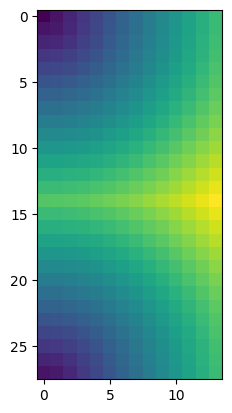

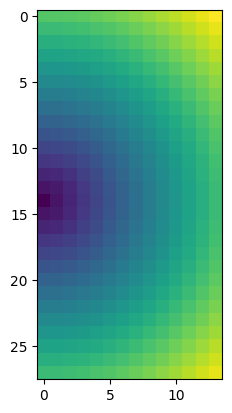

In [6]:
plt.imshow(radii);plt.show()
plt.imshow(radii_1)
np.sum(np.round(radii) < num_shells)


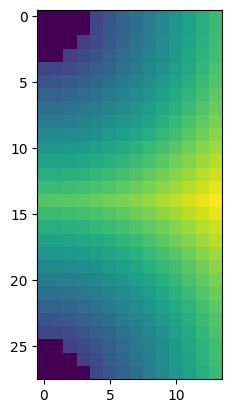

In [10]:
x, y = np.meshgrid(range(model.dft_shape[1]), range(-model.dft_shape[0] // 2, model.dft_shape[0] // 2 + 1))
radii = np.roll(np.sqrt(x ** 2 + y ** 2, dtype=np.float32), model.dft_shape[0] // 2 + 1, 0)
num_shells = 4
model.input_seq_length = np.sum(np.round(radii) < num_shells)
radii[np.round(radii) < num_shells] = 0
plt.imshow(radii);plt.show()


In [9]:

def predict_one_test_batch(num_images = 3,num_shells = model.shells):

    x, y = np.meshgrid(
                range(model.dft_shape[1]),
                range(-model.dft_shape[0] // 2, model.dft_shape[0] // 2 + 1))
    radii = np.roll(np.sqrt(x**2 + y**2, dtype=np.float32),model.dft_shape[0] // 2 + 1, 0)

    input_seq_len = np.sum(np.round(radii) < num_shells)
    
    print(f"Input Sequence Length: {input_seq_len}")
    
    for fc, (mag_min, mag_max) in dm.test_dataloader():
        break
    n_imgs  = min(num_images,fc.shape[0])
    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_min = mag_min[:n_imgs].to('cuda')
    mag_max = mag_max.to('cuda')
    mag_max = mag_max[:n_imgs].to('cuda')
    x_input = fc[:n_imgs,model.dst_flatten_order][:, :input_seq_len]

    gt = fc[:n_imgs, model.dst_flatten_order]

    with torch.no_grad():
        pred = model.sres.forward_inference(x_input,max_seq_length=gt.shape[1])
    # pred[:,:,1] = gt[:,:,1]
    # pred = torch.zeros_like(gt)
   
    lowres = torch.zeros_like(pred)
    lowres[...,0] += x_input[...,0].min()
    lowres[:, :input_seq_len] = x_input
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=gt, mag_min=mag_min, mag_max=mag_max)

    lowres_img = denormalize(lowres_img,dm.mean,dm.std)
    pred_img = denormalize(pred_img,dm.mean,dm.std)
    gt_img = denormalize(gt_img,dm.mean,dm.std)



    lowres_psnr = PSNR(gt_img,lowres_img)
    pred_psnr = PSNR(gt_img,pred_img)
    gt_psnr = PSNR(gt_img,gt_img)
    return pred_img, gt_img, lowres_img, lowres_psnr, pred_psnr, gt_psnr, num_images, input_seq_len

def plot_images(pred_img, gt_img, lowres_img, lowres_psnr, pred_psnr, gt_psnr,no_of_images = 5,input_seq_len=5,shells = model.shells):

    

    for i in [pred_img, lowres_img, gt_img]:
        i.cpu().detach().numpy()
    # for sample in range(no_of_images):
    sample = 1
    for s in range(1):
        fig2 = plt.figure(figsize=(62.5/3., 10/3.))
    
        gs = gridspec.GridSpec(1,5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        # ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[2])
        # ax3 = plt.subplot(gs[6])
        ax4 = plt.subplot(gs[4])
        # gs = gridspec.GridSpec(1,9, width_ratios=[10,0.5, 10, 0.5, 10, 0.5, 10, 0.5, 10])
        # ax0 = plt.subplot(gs[0])
        # ax1 = plt.subplot(gs[2])
        # ax2 = plt.subplot(gs[4])
        # ax3 = plt.subplot(gs[6])
        # ax4 = plt.subplot(gs[8])

        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)

        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
        ax0.set_title('Low-Resolution Input');
        ax0.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(pred_img[sample].cpu(), cmap='gray')
        ax2.set_title('Prediction');
        ax2.set_xlabel(f'Shells : {shells}, Input Sequence Length: {input_seq_len}')
        ax2.axis('equal');


        ax4.xaxis.set_major_locator(plt.NullLocator())
        ax4.yaxis.set_major_locator(plt.NullLocator())
        ax4.imshow(gt_img[sample].cpu(), cmap='gray')
        ax4.set_title('Ground Truth');
        ax4.axis('equal');

        # ax1.xaxis.set_major_locator(plt.NullLocator())
        # ax1.yaxis.set_major_locator(plt.NullLocator())
        # lowres_psnr = PSNR(gt_img, lowres_img)
        # ax1.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        # ax1.set_title('Low-Resolution Input');
        # ax1.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        # ax1.axis('equal');

        # ax3.xaxis.set_major_locator(plt.NullLocator())
        # ax3.yaxis.set_major_locator(plt.NullLocator())
        # ax3.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        # pred_psnr = PSNR(gt_img, pred_img)
        # ax3.set_title('Prediction');
        # ax3.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        # ax3.axis('equal');
        plt.savefig(f'/home/aman.kukde/Projects/FourierImageTransformer/aman/img_2/{shells}.jpg')
        plt.close()



b = np.arange(1,32,2)
for i in b:
    pred_img, gt_img, lowres_img, lowres_psnr, pred_psnr, gt_psnr, no_of_images,input_seq_len = predict_one_test_batch(num_images = 6,num_shells=i)
    plot_images(pred_img, gt_img, lowres_img, lowres_psnr, pred_psnr, gt_psnr, no_of_images,input_seq_len, shells = i)

from PIL import Image
from natsort import natsorted
import glob

# Create the frames
frames = []
imgs = glob.glob("/home/aman.kukde/Projects/FourierImageTransformer/aman/img_2/*.jpg")
for i in natsorted(imgs):
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('png_to_gif_2.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

Input Sequence Length: 1
torch.Size([2016, 2])
Input Sequence Length: 13
torch.Size([2016, 2])
Input Sequence Length: 39
torch.Size([2016, 2])
Input Sequence Length: 75
torch.Size([2016, 2])
Input Sequence Length: 121
torch.Size([2016, 2])
Input Sequence Length: 185
torch.Size([2016, 2])
Input Sequence Length: 257
torch.Size([2016, 2])
Input Sequence Length: 347
torch.Size([2016, 2])
Input Sequence Length: 447
torch.Size([2016, 2])
Input Sequence Length: 561
torch.Size([2016, 2])
Input Sequence Length: 677
torch.Size([2016, 2])
Input Sequence Length: 821
torch.Size([2016, 2])
Input Sequence Length: 967
torch.Size([2016, 2])
Input Sequence Length: 1135
torch.Size([2016, 2])
Input Sequence Length: 1309
torch.Size([2016, 2])
Input Sequence Length: 1497
torch.Size([2016, 2])
